In [1]:
from distributed import Client
client = Client()

In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask import delayed
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import datetime as dt
import tabula as tb
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
import scipy.stats as sp
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score
from functions import *

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [3]:
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

<p>Nutriscore variables nécessaires :
<ul>
    <li>Energy density (kJ/100g)</li>
    <li>Sugars (g/100g)</li>
    <li>Saturated fatty acids (g/100g)</li>
    <li>Sodium (mg/100g)</li>
    <li>Fruits,vegetables,pulses, nuts, and rapeseed, walnut and olive oils (%)</li>
    <li>Fibre (g/100g)</li>
    <li>Protein (g/100g)</li>
    <li>Ratio total saturated fatty acids/lipids (%)</li>
</ul></p>

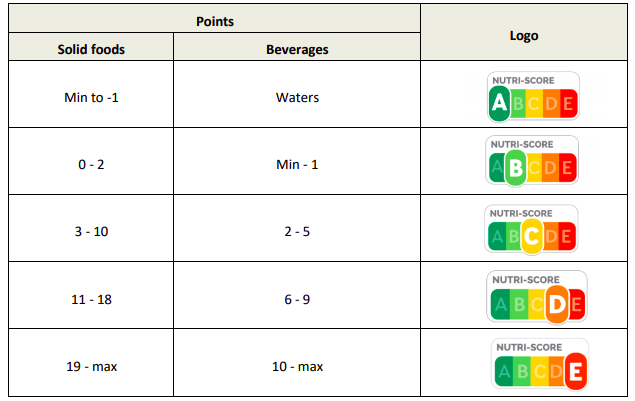

In [4]:
minus_point = tb.read_pdf("data/Nutriscore.pdf", pages='28', pandas_options={'header':1})
minus_point2 = tb.read_pdf("data/Nutriscore.pdf", pages='30', pandas_options={'header':1})

Got stderr: sept. 04, 2021 1:42:23 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
AVERTISSEMENT: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'
sept. 04, 2021 1:42:24 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
AVERTISSEMENT: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'

Got stderr: sept. 04, 2021 1:42:25 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
AVERTISSEMENT: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'
sept. 04, 2021 1:42:25 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
AVERTISSEMENT: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'



In [5]:
minus_point = minus_point[0]
minus_point = minus_point.drop(0)
minus_point = minus_point.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', '1'], axis = 1)
minus_point = minus_point.rename(columns={"fatty acids (g/100g)":"Saturated fatty acids (g/100g)"})
minus_point = minus_point.reset_index(drop=True)

In [6]:
minus_point2 = minus_point2[0]
minus_point2 = minus_point2.rename(columns={"total saturated fatty acids/lipids":
                                            "Total saturated fatty acids/lipids Ratio (%)"})
minus_point2 = minus_point2.drop([0, 1])
minus_point2 = minus_point2.reset_index(drop = True)

In [7]:
minus_point = pd.concat([minus_point, minus_point2.iloc[:,1]], axis = 1)
minus_point = minus_point.drop("Saturated fatty acids (g/100g)", axis = 1)
minus_point.iloc[:, 1:] = minus_point.iloc[:, 1:].applymap(lambda x: x[1:])
minus_point.iloc[:, 1:] = minus_point.iloc[:, 1:].astype(float)
minus_point.iloc[:, 0] = minus_point.iloc[:, 0].astype(int)

del minus_point2

In [8]:
minus_point.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 5 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Points                                        11 non-null     int64  
 1   Energy density (kJ/100g)                      11 non-null     float64
 2   Sugars (g/100g)                               11 non-null     float64
 3   Sodium (mg/100g)                              11 non-null     float64
 4   Total saturated fatty acids/lipids Ratio (%)  11 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 568.0 bytes


In [9]:
plus_point = tb.read_pdf("data/Nutriscore.pdf", pages='29', pandas_options={'header':1})

Got stderr: sept. 04, 2021 1:42:26 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
AVERTISSEMENT: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'
sept. 04, 2021 1:42:27 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
AVERTISSEMENT: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'



In [10]:
plus_point = plus_point[0]
plus_point.columns = ["Points", "Fruits, vegetables, pulses, nuts, and rapeseed,\
 walnut and olive oils (%)", "Fibre (g/100g)", "Protein (g/100g)"]
plus_point = plus_point.drop([0,1,2,3,4,5,6])
plus_point = plus_point.reset_index(drop=True)
plus_point.iloc[:, 1:] = plus_point.iloc[:, 1:].applymap(lambda x: x[1:])
plus_point.iloc[:,1] = plus_point.iloc[:,1].replace("",60)
plus_point.iloc[:, 0] = plus_point.iloc[:, 0].astype(int)
plus_point.iloc[:, 1:] = plus_point.iloc[:, 1:].astype(float)

plus_point.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Points                                                                     6 non-null      int64  
 1   Fruits, vegetables, pulses, nuts, and rapeseed, walnut and olive oils (%)  6 non-null      float64
 2   Fibre (g/100g)                                                             6 non-null      float64
 3   Protein (g/100g)                                                           6 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 320.0 bytes


In [11]:
dtype_error = {'additives_en': 'str',
       'additives_tags': 'str',
       'brand_owner': 'str',
       'cities_tags': 'str',
       'code': 'str',
       'emb_codes': 'str',
       'emb_codes_tags': 'str',
       'first_packaging_code_geo': 'str',
       'generic_name': 'str',
       'ingredients_from_palm_oil_tags': 'str',
       'ingredients_that_may_be_from_palm_oil_tags': 'str',
       'manufacturing_places': 'str',
       'manufacturing_places_tags': 'str',
       'origins': 'str',
       'origins_en': 'str',
       'origins_tags': 'str',
       'packaging': 'str',
       'packaging_tags': 'str',
       'packaging_text': 'str',
       'purchase_places': 'str',
       'serving_size': 'str',
       'traces': 'str',
        'abbreviated_product_name':'str'}

In [12]:
keep_col = ['code',
 'url',
 'creator',
 'last_modified_datetime',
 'product_name',
 'abbreviated_product_name',
 'generic_name',
 'quantity',
 'brands',
 'brands_tags',
 'categories_en',
 'countries_en',
 'labels',
 'emb_codes',
 'emb_codes_tags',
 'ingredients_text',
 'allergens',
 'traces',
 'serving_size',
 'serving_quantity',
 'additives_n',
 'additives_en',
 'ecoscore_score_fr',
 'ecoscore_grade_fr',
 'main_category_en',
 'nutriscore_score',
 'nutriscore_grade',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'sugars_100g',
 'fiber_100g',
 'carbohydrates_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g']

In [13]:
raw_data = dd.read_csv("data/foodfacts.csv", sep = "\t", engine="python", doublequote=False, dtype=dtype_error, usecols=keep_col)

In [14]:
raw_data.columns.to_list()

['code',
 'url',
 'creator',
 'last_modified_datetime',
 'product_name',
 'abbreviated_product_name',
 'generic_name',
 'quantity',
 'brands',
 'brands_tags',
 'categories_en',
 'labels',
 'emb_codes',
 'emb_codes_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'traces',
 'serving_size',
 'serving_quantity',
 'additives_n',
 'additives_en',
 'nutriscore_score',
 'nutriscore_grade',
 'ecoscore_score_fr',
 'ecoscore_grade_fr',
 'main_category_en',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g']

In [15]:
len(raw_data)

1919562

In [16]:
raw_data = raw_data[raw_data["countries_en"]=="France"].compute()
raw_data = raw_data.reset_index()
raw_data = raw_data.rename(columns={'fruits-vegetables-nuts_100g':'fruits_vegetables_nuts_100g',
       'fruits-vegetables-nuts-dried_100g':'fruits_vegetables_nuts_dried_100g',
       'fruits-vegetables-nuts-estimate_100g':'fruits_vegetables_nuts_estimate_100g'})

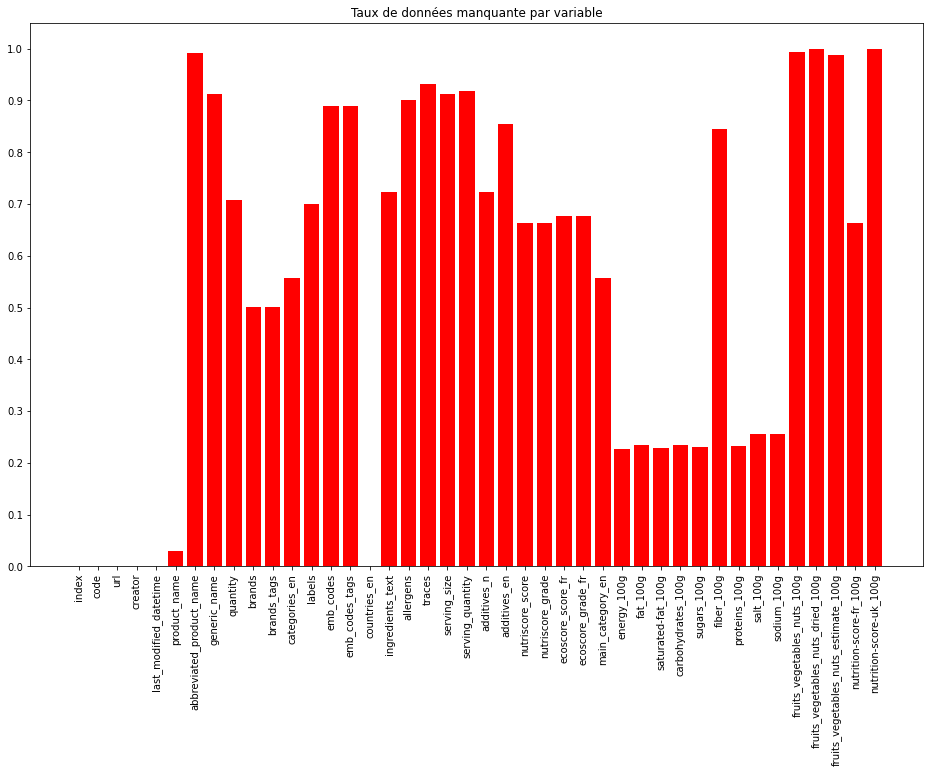

In [17]:
temp_NA_raw = raw_data.isna().mean()

fig, ax = plt.subplots(figsize=(16, 10))
ax.bar(x= temp_NA_raw.index, height =  temp_NA_raw.values, color = "red")
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.05, 0.1))
plt.title("Taux de données manquante par variable")
plt.show()

In [18]:
raw_data.shape

(756204, 42)

In [19]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756204 entries, 0 to 756203
Data columns (total 42 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   index                                 756204 non-null  int64  
 1   code                                  756204 non-null  object 
 2   url                                   756204 non-null  object 
 3   creator                               756203 non-null  object 
 4   last_modified_datetime                756204 non-null  object 
 5   product_name                          734054 non-null  object 
 6   abbreviated_product_name              6259 non-null    object 
 7   generic_name                          66513 non-null   object 
 8   quantity                              220545 non-null  object 
 9   brands                                377706 non-null  object 
 10  brands_tags                           377670 non-null  object 
 11  

In [20]:
raw_data["last_modified_datetime"] = pd.to_datetime(raw_data["last_modified_datetime"])

In [21]:
raw_data.shape

(756204, 42)

In [22]:
mask = raw_data.duplicated(subset="code", keep=False)
doublon = raw_data[mask]

In [23]:
doublon

,index,code,url,creator,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,brands,brands_tags,categories_en,labels,emb_codes,emb_codes_tags,countries_en,ingredients_text,allergens,traces,serving_size,serving_quantity,additives_n,additives_en,nutriscore_score,nutriscore_grade,ecoscore_score_fr,ecoscore_grade_fr,main_category_en,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits_vegetables_nuts_100g,fruits_vegetables_nuts_dried_100g,fruits_vegetables_nuts_estimate_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
172133,8578,30383354190402,http://world-en.openfoodfacts.org/product/3038...,openfoodfacts-contributors,2021-01-15 09:21:20+00:00,basilic,NaN,NaN,210 g,panzani,panzani,"Groceries,Sauces,Tomato sauces","Nutriscore,Nutriscore A",NaN,NaN,France,Pulpe de tomates fraîches avec morceaux et pur...,NaN,NaN,NaN,NaN,1.0,E14XX - Modified Starch,2.0,b,NaN,NaN,Tomato sauces,261.0,3.00,0.30,6.100000,5.50,2.2,1.700000,0.99,0.396,NaN,NaN,NaN,2.0,NaN
172134,8579,30383354190402,http://world-en.openfoodfacts.org/product/3038...,openfoodfacts-contributors,2021-01-15 09:23:03+00:00,basilic,NaN,NaN,210 g,panzani,panzani,"Groceries,Sauces,Tomato sauces","Nutriscore, Nutriscore A",NaN,NaN,France,Pulpe de tomates fraîches avec morceaux et pur...,NaN,NaN,NaN,NaN,1.0,E14XX - Modified Starch,-3.0,a,84.0,a,Tomato sauces,261.0,3.00,0.30,6.100000,5.50,2.2,1.700000,0.99,0.396,NaN,NaN,92.0,-3.0,NaN
402476,27183,3560070278831,http://world-en.openfoodfacts.org/product/3560...,openfoodfacts-contributors,2021-04-17 07:44:17+00:00,"Pamplemousse rose, 100 % Pur Fruit Pressé",NaN,"Jus de pamplemousse rose - Pamplemousse Rose, ...",1 L e,"Carrefour,CMI (Carrefour Marchandises Internat...","carrefour,cmi-carrefour-marchandises-internati...","Pure-grapefruit-juice,Beverages,Fruit-based be...","en:distributor-labels,en:carrefour-quality,en:...","EMB 36229,EMB 45273,EMB 67434,emb-36229m","emb-36229,emb-45273,emb-67434,emb-36229m",France,"Jus de pamplemousse rose, pulpe (2%).",NaN,NaN,200ml,200.0,0.0,NaN,2.0,c,NaN,NaN,Squeezed juices,151.0,0.00,0.00,8.500000,8.50,NaN,0.000000,0.00,0.000,100.0,NaN,NaN,2.0,NaN
402477,27184,3560070278831,http://world-en.openfoodfacts.org/product/3560...,openfoodfacts-contributors,2021-05-21 06:06:39+00:00,"Pamplemousse rose, 100 % Pur Fruit Pressé",NaN,"Jus de pamplemousse rose - Pamplemousse Rose, ...",1 L e,"Carrefour,CMI (Carrefour Marchandises Internat...","carrefour,cmi-carrefour-marchandises-internati...","Plant-based foods and beverages,Beverages,Plan...","Labels de distributeurs, Qualité Carrefour, Po...","EMB 36229,EMB 45273,EMB 67434,emb-36229m","emb-36229,emb-45273,emb-67434,emb-36229m",France,"Jus de pamplemousse rose, pulpe (2%).",NaN,NaN,200ml,200.0,0.0,NaN,2.0,c,35.0,d,Pure-grapefruit-juice,151.0,0.00,0.00,8.500000,8.50,NaN,0.000000,0.00,0.000,100.0,NaN,NaN,2.0,NaN
546798,18798,3770008983205,http://world-en.openfoodfacts.org/product/3770...,r-x,2021-02-25 08:40:12+00:00,REMYX VODKA Aquatique,NaN,Vodka,70 cl,REMYX VODKA,remyx-vodka,"Beverages,Alcoholic beverages,Hard liquors,Eau...",NaN,NaN,NaN,France,"eau, blé de printemps, alcool",NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Vodka,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546799,18799,3770008983205,http://world-en.openfoodfacts.org/product/3770...,r-x,2021-02-25 08:40:12+00:00,REMYX VODKA Aquatique,NaN,Vodka,70 cl,REMYX VODKA,remyx-vodka,"Beverages,Alcoholic beverages,Hard liquors,Eau...",NaN,NaN,NaN,France,"eau, blé de printemps, alcool",NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,74.0,b,Vodka,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
646093,14096,6703501220017,http://world-en.openfoodfacts.org/product/6703...,kiliweb,2021-06-25 16:23:52+00:00,Farine T45,NaN,NaN,1 kg,Minoterie Burggraf-Becker,minoterie-burggraf-becker,"Plant-based foods and beverages,Plant-based fo...",NaN,NaN,NaN,France,Farine t45,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,115.0,a,Wheat flour 

In [24]:
del doublon, mask

raw_data = raw_data.sort_values("last_modified_datetime", ascending=False)\
    .drop_duplicates(subset="code", keep="first")

In [25]:
raw_data.shape

(756200, 42)

In [26]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756200 entries, 7811 to 218654
Data columns (total 42 columns):
 #   Column                                Non-Null Count   Dtype              
---  ------                                --------------   -----              
 0   index                                 756200 non-null  int64              
 1   code                                  756200 non-null  object             
 2   url                                   756200 non-null  object             
 3   creator                               756199 non-null  object             
 4   last_modified_datetime                756200 non-null  datetime64[ns, UTC]
 5   product_name                          734050 non-null  object             
 6   abbreviated_product_name              6259 non-null    object             
 7   generic_name                          66511 non-null   object             
 8   quantity                              220541 non-null  object             
 9   b

In [27]:
raw_data = raw_data.astype({"code":float, "url":str, "product_name":str,
                 "abbreviated_product_name":str})
raw_data.dtypes

index                                                 int64
code                                                float64
url                                                  object
creator                                              object
last_modified_datetime                  datetime64[ns, UTC]
product_name                                         object
abbreviated_product_name                             object
generic_name                                         object
quantity                                             object
brands                                               object
brands_tags                                          object
categories_en                                        object
labels                                               object
emb_codes                                            object
emb_codes_tags                                       object
countries_en                                         object
ingredients_text                        

In [28]:
raw_data.describe()

,index,code,serving_quantity,additives_n,nutriscore_score,ecoscore_score_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits_vegetables_nuts_100g,fruits_vegetables_nuts_dried_100g,fruits_vegetables_nuts_estimate_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,756200.000000,7.562000e+05,62061.000000,209600.000000,254653.000000,243856.000000,5.843260e+05,578776.000000,582645.000000,578703.000000,581755.000000,116732.000000,580466.000000,563432.000000,563431.000000,5390.000000,283.000000,9437.000000,254657.000000,6.000000
mean,13859.923848,8.608811e+49,121.815100,1.594509,9.475989,43.220409,1.168717e+03,14.269256,5.428754,26.985480,13.607901,2.913979,9.149704,1.281172,0.512579,40.204645,15.176005,46.848921,9.476135,13.166667
std,8123.863522,7.486202e+52,798.490737,2.375537,8.724963,27.381615,1.060714e+04,41.965835,8.389778,253.864528,40.657084,5.027391,96.333760,19.388372,7.755666,35.925860,30.116265,28.413682,8.724984,9.282600
min,0.000000,2.000000e+00,0.000000,0.000000,-15.000000,-28.000000,0.000000e+00,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,1.000000
25%,6803.000000,3.055150e+12,30.000000,0.000000,2.000000,24.000000,4.690000e+02,1.000000,0.200000,2.300000,0.600000,0.100000,1.500000,0.060000,0.024000,5.830000,0.000000,19.000000,2.000000,5.500000
50%,13833.000000,3.450612e+12,90.000000,1.000000,10.000000,38.000000,1.088000e+03,8.000000,2.000000,13.500000,3.200000,1.600000,6.300000,0.550000,0.220000,33.000000,0.000000,50.000000,10.000000,15.500000
75%,20747.000000,4.002631e+12,145.000000,2.000000,16.000000,65.000000,1.669000e+03,22.130000,8.000000,51.000000,19.000000,3.500000,13.000000,1.310000,0.524000,66.000000,7.000000,64.000000,16.000000,21.000000
max,30868.000000,6.509983e+55,100000.000000,30.000000,40.000000,125.000000,8.010000e+06,29000.000000,2000.000000,192000.000000,27000.000000,100.000000,73000.000000,14000.000000,5600.000000,100.000000,100.000000,100.000000,40.000000,22.000000



<p>On peut remarquer ici plusieurs incohérences :
<ul>
    <li>energy_100g : Max supérieur à 10000 (valeur = 8010000)</li>
    <li>fat_100g : Max supérieur à 100g (valeur = 29000)</li>
    <li>saturated-fat_100g : Max supérieur à 100g (valeur = 2000)</li>
    <li>sugars_100g : Max supérieur à 100g (valeur = 27000) et min inférieur à 0 (valeur = -1)</li>
    <li>proteins_100g : Max supérieur à 100g (valeur = 73000)</li>
    <li>sodium_100g : Max supérieur à 100g (valeur = 73000)</li>
</ul></p>

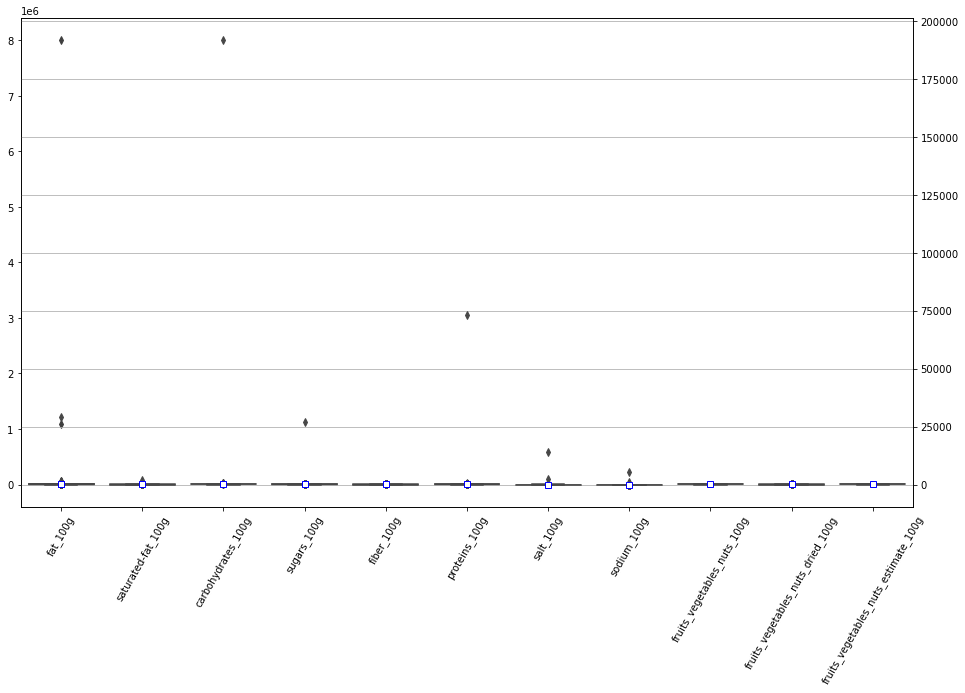

In [29]:
raw_data["aggregate_100g"] = raw_data['fat_100g'] + raw_data['carbohydrates_100g'] + raw_data['proteins_100g'] + raw_data['salt_100g']

temp = raw_data.iloc[:,28]
temp2 = raw_data.iloc[:,29:40]

f, ax = plt.subplots(figsize=(16,9))
plt.xticks(rotation = 60)
ax2 = ax.twinx()

sns.boxplot(data=temp, dodge=False, orient = 'v', showfliers = True, showmeans = True,\
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, ax=ax)

sns.boxplot(data=temp2, dodge=False, orient = 'v', showfliers = True, showmeans = True,\
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, ax=ax2)


plt.grid()
plt.draw()

In [39]:
check_error = {"energy_100g":np.array([raw_data[raw_data["energy_100g"] > 10000],
                                     raw_data[raw_data["energy_100g"] < 0]], dtype='object'),
              "fat_100g":np.array([raw_data[raw_data["fat_100g"] > 100],
                                     raw_data[raw_data["fat_100g"] < 0]], dtype='object'),
              "saturated-fat_100g":np.array([raw_data[raw_data["fat_100g"] < raw_data["saturated-fat_100g"]], raw_data[raw_data["saturated-fat_100g"] > 100],
                                     raw_data[raw_data["saturated-fat_100g"] < 0]], dtype='object'),
              "carbohydrates_100g":np.array([raw_data[raw_data["carbohydrates_100g"] > 100],
                                     raw_data[raw_data["carbohydrates_100g"] < 0]], dtype='object'), 
              "sugars_100g":np.array([raw_data[raw_data["sugars_100g"] > 100],
                                     raw_data[raw_data["sugars_100g"] < 0]], dtype='object'),
              "proteins_100g":np.array([raw_data[raw_data["proteins_100g"] > 100],
                                     raw_data[raw_data["proteins_100g"] < 0]], dtype='object'),
              "salt_100g":np.array([raw_data[raw_data["salt_100g"] > 100],
                                     raw_data[raw_data["salt_100g"] < 0]], dtype='object'),
              "sodium_100g":np.array([raw_data[raw_data["sodium_100g"] > 100],
                                     raw_data[raw_data["sodium_100g"] < 0]], dtype='object'),
              "fruits_vegetables_nuts_100g":np.array([raw_data[raw_data["fruits_vegetables_nuts_100g"] > 100],
                                     raw_data[raw_data["fruits_vegetables_nuts_100g"] < 0]], dtype='object'),
              "fruits_vegetables_nuts_dried_100g":np.array([raw_data[raw_data["fruits_vegetables_nuts_dried_100g"] > 100],
                                     raw_data[raw_data["fruits_vegetables_nuts_dried_100g"] < 0]], dtype='object'),
              "fruits_vegetables_nuts_estimate_100g":np.array([raw_data[raw_data["fruits_vegetables_nuts_estimate_100g"] > 100],
                                     raw_data[raw_data["fruits_vegetables_nuts_estimate_100g"] < 0]], dtype='object')}

error_data = raw_data[(raw_data["energy_100g"] > 10000) | (raw_data["energy_100g"] < 0) | (raw_data["fat_100g"] > 100)\
            | (raw_data["fat_100g"] < 0) | (raw_data["saturated-fat_100g"] > 100) | (raw_data["saturated-fat_100g"] < 0)\
            | (raw_data["saturated-fat_100g"] > raw_data["fat_100g"])\
            | (raw_data["sugars_100g"] > 100) | (raw_data["sugars_100g"] < 0) | (raw_data["proteins_100g"] > 100)\
            | (raw_data["proteins_100g"] < 0) | (raw_data["salt_100g"] > 100) | (raw_data["salt_100g"] < 0) \
            | (raw_data["sodium_100g"] > 100) | (raw_data["sodium_100g"] < 0) | (raw_data["sodium_100g"] > raw_data["salt_100g"])\
            | (raw_data["fruits_vegetables_nuts_dried_100g"] > 100) | (raw_data["fruits_vegetables_nuts_dried_100g"] < 0)\
            | (raw_data["fruits_vegetables_nuts_100g"] > 100) | (raw_data["fruits_vegetables_nuts_100g"] < 0)\
            | (raw_data["fruits_vegetables_nuts_estimate_100g"] > 100) | (raw_data["fruits_vegetables_nuts_estimate_100g"] < 0)
                      | (raw_data["carbohydrates_100g"] > 100) | (raw_data["carbohydrates_100g"] < 0)]

In [40]:
#raw_data["aggregate_100g"] = raw_data['fat_100g'] + raw_data['carbohydrates_100g'] + raw_data['proteins_100g'] + raw_data['salt_100g']
#l_aggre = ['fat_100g','carbohydrates_100g','proteins_100g','salt_100g']

#for label, row  in raw_data[raw_data["aggregate_100g"]>100].iterrows():
#    a = row["aggregate_100g"] - 100
#    for i in l_aggre:
#        raw_data.loc[label, i] = np.round(raw_data.loc[label, i] - np.round(a * (row[i]/row["aggregate_100g"]),decimals = 2),decimals = 2)
        

In [41]:

raw_data_noerror = raw_data.drop(error_data.index.to_list())

for key, value in check_error.items():
    for item in value:
        print(item.size)
        if item.size == 0:
            continue
        for label, row in item.iterrows():
            if key == "saturated-fat_100g" and row["saturated-fat_100g"] > row["fat_100g"]:
                raw_data.loc[label, "saturated-fat_100g"] = raw_data.loc[label, "fat_100g"]
            elif key == "sodium_100g" and raw_data.loc[label, "sodium_100g"] > raw_data.loc[label, "salt_100g"]:
                raw_data.loc[label, "sodium_100g"] = raw_data.loc[label, "salt_100g"]
            elif key == "sugar_100g" and raw_data.loc[label, sugar_100g] > raw_data.loc[label, "carbohydrates_100g"]:
                raw_data.loc[label, "sugar_100g"] = raw_data.loc[label, "carbohydrates_100g"]
            elif raw_data_noerror.loc[raw_data_noerror["categories_en"] == row["categories_en"], key].empty == True:
                raw_data.loc[label, key] = np.around(raw_data_noerror.loc[:, key].mean(), decimals=2)
            else:
                raw_data.loc[label, key] = np.around(raw_data_noerror.loc[raw_data_noerror["categories_en"] == row["categories_en"], key].mean(), decimals=2)


del raw_data_noerror, check_error, error_data

0
0
0
0
9546
5.42
0.6
5.42
1.8
1.45
0.8
5.42
0.05
5.42
3.0
5.42
4.1
5.42
0.1
5.42
3.0
5.42
3.1
5.42
0.5
5.42
0.5
5.42
0.5
5.42
0.5
13.93
1.5
5.42
0.9
5.42
2.9
5.42
3.0
5.42
2.7
5.42
4.0
5.42
2.19
5.42
0.73
5.42
5.0
5.42
2.0
5.42
5.0
120.0
23.2
0.5
0.0
0.1
0.0
89.5
26.7
0.1
0.0
10.0
0.0
4.0
3.3
0.1
0.0
23.0
3.4
0.86
0.1
13.0
7.6
11.2
7.6
0.1
0.0
17.0
16.0
0.5
0.100000001490116
0.1
0.0
64.0
26.0
4.80000019073486
1.29999995231628
4.9
1.5
6.9
0.5
2000.0
8.17
28.3
17.5
2.8
0.5
0.1
0.0
2.2000000476837
0.9
3.2
0.0
405.000019073486
14.21
153.0
24.0
0.01
0.0
23.0
14.21
5.0
0.0
54.0
12.0
3.5
2.7
1.9
0.0
12.0
6.5
0.1
0.0
3.9
0.3
0.4
0.0
2.0
0.0
0.2
0.0
5.8000001907349
1.0
8.7
3.0
0.01
0.0
0.01
0.0
0.01
0.0
3.9000000953674
0.0
0.1
0.0
14.05
11.8
19.6
7.6
0.1
0.0
5.2
1.9
5.9
5.7
34.0
13.0
6.0
0.0
0.1
0.0
189.0
30.0
0.5
0.3
0.02
0.0
0.1
0.0
0.2
0.0
0.4
0.0
11.1111111111111
2.22222222222222
0.1
0.0
8.0
0.0
0.30000001192093
1.9e-06
0.3
0.0
0.2
0.0
0.5
0.0
1.1
1.0
75.8
14.2
1.0
0.0
2.7
0.0
12.8
7.7
0.1

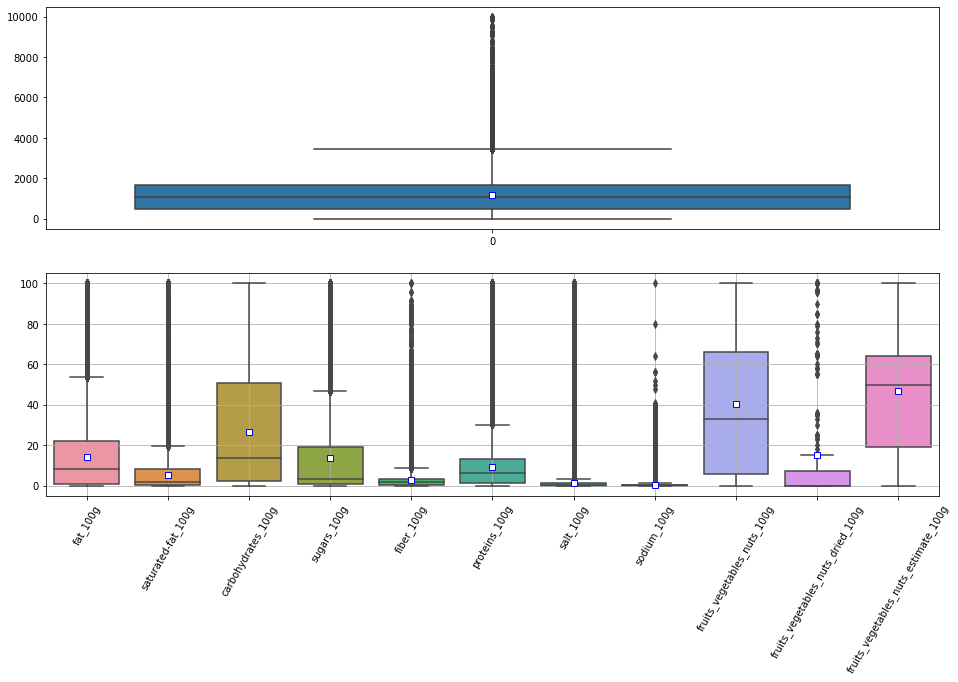

In [42]:
temp = raw_data.iloc[:,28]
temp2 = raw_data.iloc[:,29:40]

f, axs = plt.subplots(2,1,figsize=(16,9))
plt.xticks(rotation = 60)
ax = axs[0]
ax2 = axs[1]

sns.boxplot(data=temp, dodge=False, orient = 'v', showfliers = True, showmeans = True,\
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, ax=ax)

sns.boxplot(data=temp2, dodge=False, orient = 'v', showfliers = True, showmeans = True,\
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, ax=ax2)


plt.grid()
plt.draw()

del temp, temp2

In [43]:
raw_data["ratio_saturatedfat_fat(%)"] = np.round(raw_data.dropna(subset=["saturated-fat_100g", "fat_100g"])["saturated-fat_100g"]
                                                 / raw_data.dropna(subset=["saturated-fat_100g", "fat_100g"])["fat_100g"], decimals=2)
raw_data["ratio_saturatedfat_fat(%)"] = raw_data["ratio_saturatedfat_fat(%)"].replace([np.inf, -np.inf], np.nan)


Nutri_set = raw_data.loc[:, ['nutriscore_grade','energy_100g', "ratio_saturatedfat_fat(%)", 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'fruits_vegetables_nuts_100g',
       'fruits_vegetables_nuts_dried_100g',
       'fruits_vegetables_nuts_estimate_100g']].dropna(subset=['nutriscore_grade'])

In [44]:
temp_raw = Nutri_set
temp_raw = temp_raw.melt(id_vars = 'nutriscore_grade',value_vars=temp_raw.columns[1:]).dropna()

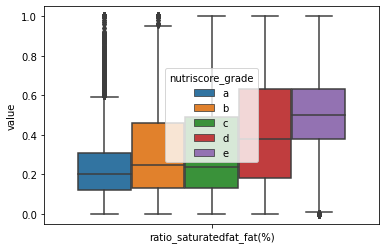

In [47]:
sns.boxplot(data=temp_raw[temp_raw['variable']=="ratio_saturatedfat_fat(%)"], x='variable', y='value', hue="nutriscore_grade",
                hue_order=["a","b","c","d","e"]).set(xlabel=None)
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


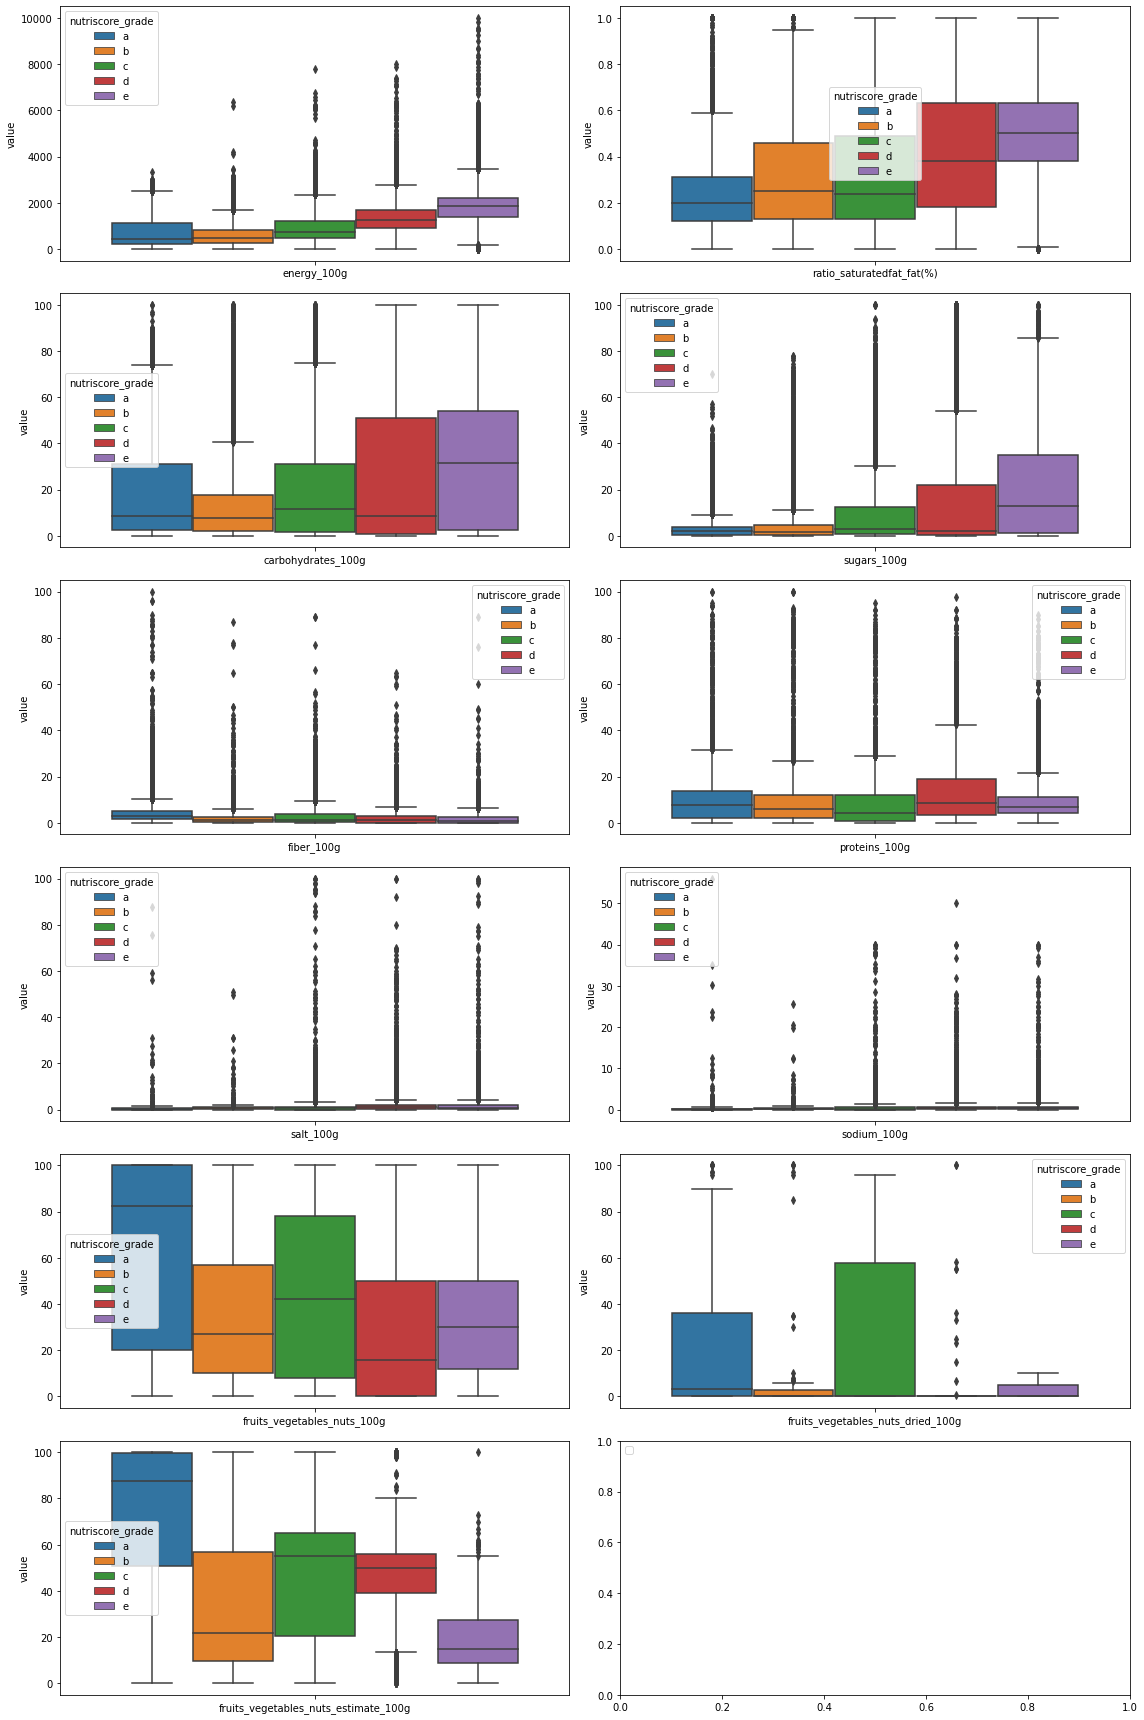

In [48]:
choices = Nutri_set.columns

f, axs = plt.subplots(6,2, figsize = (16, 24))

i=1
choices[i]

for ix,iy in np.ndindex(axs.shape):
    if i == len(choices) :
        break
    else:
        sns.boxplot(data=temp_raw[temp_raw['variable']==choices[i]], x='variable', y='value', hue="nutriscore_grade",
                    hue_order=["a","b","c","d","e"], ax=axs[ix,iy]).set(xlabel=None)

        plt.legend(loc = 'upper left')
        i+=1



plt.tight_layout()

del choices, temp_raw

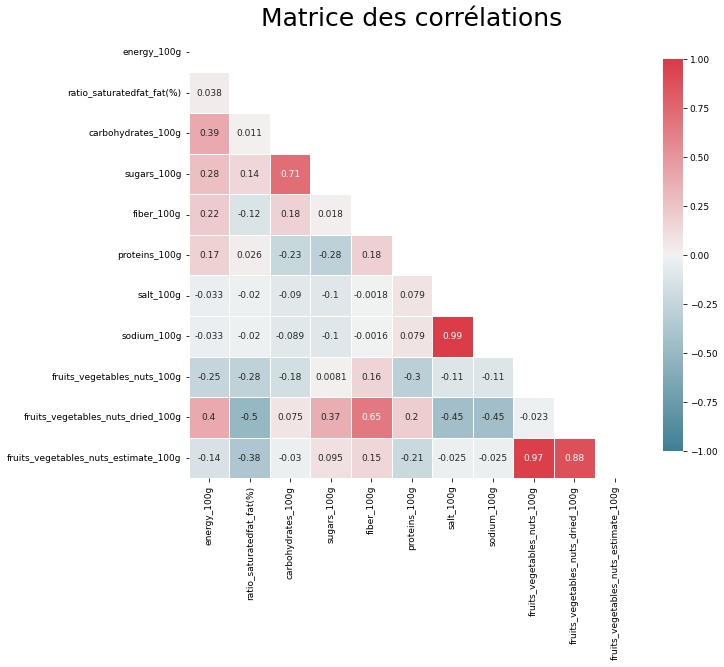

In [49]:
matrice_correlation = raw_data.loc[:,Nutri_set.columns]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 9}

plt.rc('font', **font)

# Compute the correlation matrix
corr = matrice_correlation.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmin=-1,vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot = True, ax = ax).set_title("Matrice des corrélations", size = 25)

plt.draw()

In [50]:
Nutri_set = Nutri_set.drop(["sodium_100g", "fruits_vegetables_nuts_dried_100g", "fruits_vegetables_nuts_estimate_100g"],axis=1)

In [51]:
samples_data = Nutri_set.sample(frac=0.50, random_state=1)
len(samples_data)

127326

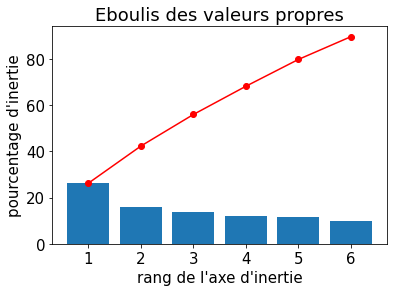

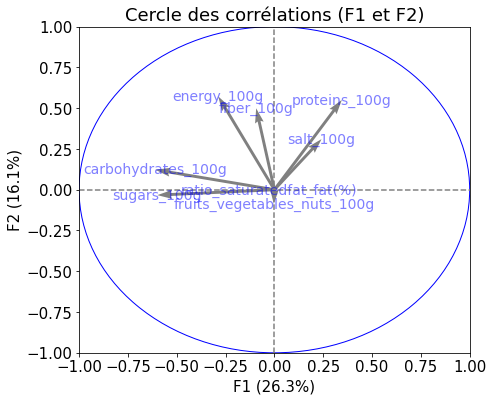

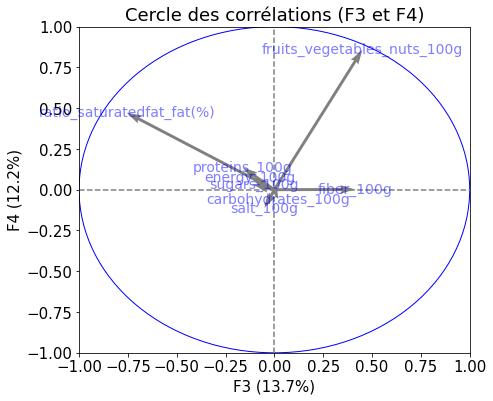

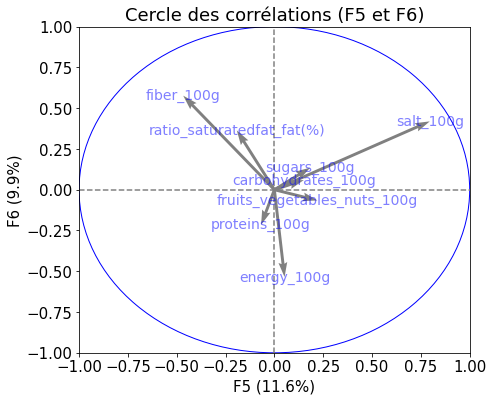

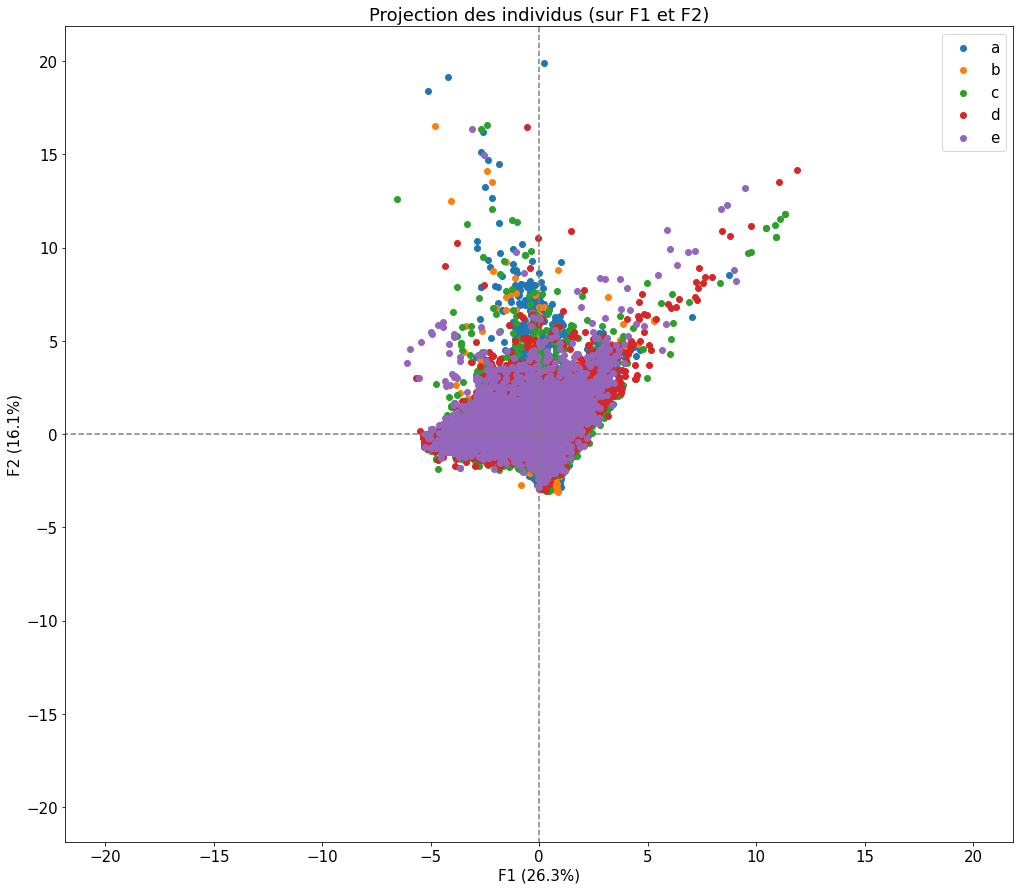

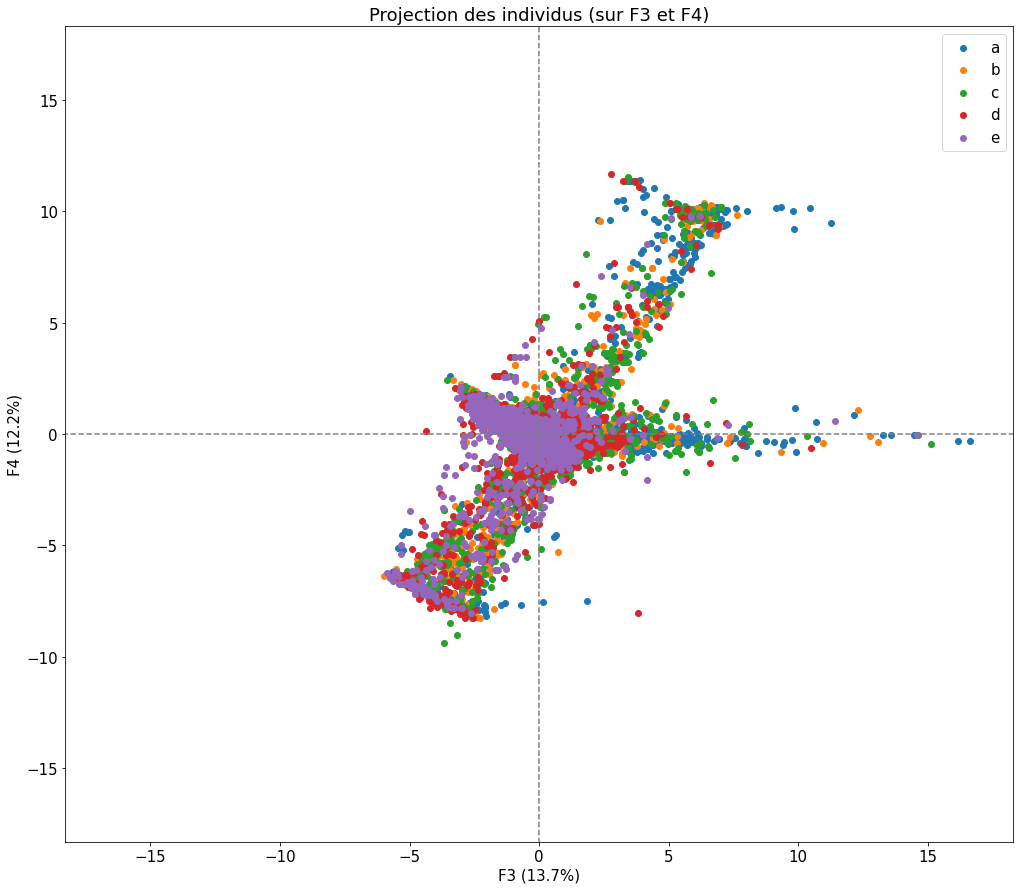

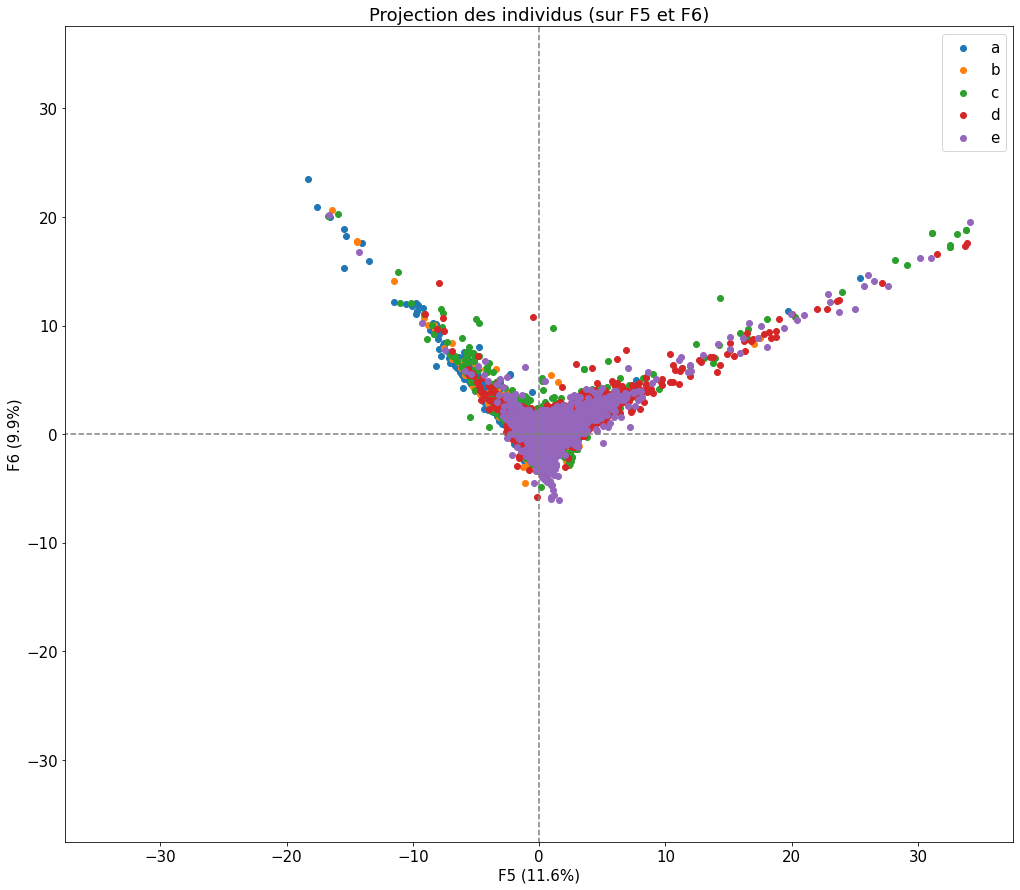

In [52]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

data = Nutri_set
data = data.iloc[:,1:]

samples_data = Nutri_set.sample(frac=0.50, random_state=1)

# choix du nombre de composantes à calculer
n_comp = 6

# préparation des données pour l'ACP
data_pca = data.fillna(data.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = data_pca.index # ou data.index pour avoir les intitulés
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = PCA(n_components=n_comp)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)
# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

# Projection des individus

# préparation des données pour l'ACP
data_pca = samples_data.iloc[:,1:].fillna(data.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values


# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled2 = std_scale.transform(X)

X_projected2 = pca.transform(X_scaled2)

display_factorial_planes(X_projected2, n_comp, pca, [(0,1),(2,3),(4,5)], labels = samples_data.index, illustrative_var = samples_data.iloc[:,0])
 
plt.show()


In [53]:
temp_ctr_cos2 = data.copy()

n = temp_ctr_cos2.shape[0]
p = temp_ctr_cos2.shape[1]
eigval = (n-1)/n*pca.explained_variance_


temp_ctr_cos2["Coord_C1"] = X_projected[:,0]
temp_ctr_cos2["Coord_C2"] = X_projected[:,1]
temp_ctr_cos2["Coord_C3"] = X_projected[:,2]
temp_ctr_cos2["Coord_C4"] = X_projected[:,3]
temp_ctr_cos2["CTR"] = np.sum(X_scaled**2, axis = 1)
temp_ctr_cos2["Cos2_1"] = round(((temp_ctr_cos2["Coord_C1"]**2)/temp_ctr_cos2["CTR"])*100,3)
temp_ctr_cos2["Cos2_2"] = round(((temp_ctr_cos2["Coord_C2"]**2)/temp_ctr_cos2["CTR"])*100,3)
temp_ctr_cos2["Cos2_3"] = round(((temp_ctr_cos2["Coord_C3"]**2)/temp_ctr_cos2["CTR"])*100,3)
temp_ctr_cos2["Cos2_4"] = round(((temp_ctr_cos2["Coord_C4"]**2)/temp_ctr_cos2["CTR"])*100,3)
temp_ctr_cos2["Cum_Cos2_1&2"] = round((temp_ctr_cos2["Cos2_1"]+temp_ctr_cos2["Cos2_2"]),3)
#temp_ctr_cos2["Cum_Cos2"] = temp_ctr_cos2["Cum_Cos2"].map(str) + "%"
#temp_ctr_cos2["Cos2_1"] = temp_ctr_cos2["Cos2_1"].map(str)+"%"
#temp_ctr_cos2["Cos2_2"] = temp_ctr_cos2["Cos2_2"].map(str)+"%"
#temp_ctr_cos2["Cos2_3"] = temp_ctr_cos2["Cos2_3"].map(str)+"%"
temp_ctr_cos2["CTR_1"] = (temp_ctr_cos2["Coord_C1"]**2)/(n*eigval[0])
temp_ctr_cos2["CTR_2"] = (temp_ctr_cos2["Coord_C2"]**2)/(n*eigval[1])
temp_ctr_cos2["CTR_3"] = (temp_ctr_cos2["Coord_C3"]**2)/(n*eigval[2])
temp_ctr_cos2["CTR_4"] = (temp_ctr_cos2["Coord_C4"]**2)/(n*eigval[3])


sqrt_eigval = np.sqrt(eigval)

corvar = np.zeros((p,p))
corr = np.zeros((p,p))
for k in range(4):
    corr[:,k] = pcs[k,:]
    corvar[:,k] = pcs[k,:] * sqrt_eigval[k]

cos2var = corvar**2
temp1 = pd.DataFrame({'id':data.columns,'CORR_1':corr[:,0],'CORR_2':corr[:,1],'CORR_3':corr[:,2], 'CORR_4':corr[:,3],
                      'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1],'COS2_3':cos2var[:,2], 'COS2_4':cos2var[:,3]})

ctrvar = cos2var

temp1["CTR_1"] = ctrvar[:,0]/eigval[0]
temp1["CTR_2"] = ctrvar[:,1]/eigval[1]
temp1["CTR_3"] = ctrvar[:,2]/eigval[2]
temp1["CTR_4"] = ctrvar[:,3]/eigval[3]

In [54]:
temp1

,id,CORR_1,CORR_2,CORR_3,CORR_4,COS2_1,COS2_2,COS2_3,COS2_4,CTR_1,CTR_2,CTR_3,CTR_4
0,energy_100g,-0.287327,0.572112,-0.123949,0.076992,0.173464,0.421027,0.016803,0.005796,0.082557,0.327312,0.015363,0.005928
1,ratio_saturatedfat_fat(%),-0.027159,-0.004188,-0.755812,0.472385,0.001550,0.000023,0.624772,0.218195,0.000738,0.000018,0.571252,0.223147
2,carbohydrates_100g,-0.609079,0.122292,0.019651,-0.057901,0.779479,0.019237,0.000422,0.003278,0.370977,0.014955,0.000386,0.003353
3,sugars_100g,-0.599513,-0.033157,-0.106067,0.029563,0.755187,0.001414,0.012304,0.000855,0.359416,0.001099,0.011250,0.000874
4,fiber_100g,-0.093208,0.499328,0.412528,0.001879,0.018254,0.320716,0.186123,0.000003,0.008688,0.249329,0.170180,0.000004
5,proteins_100g,0.345504,0.550812,-0.161721,0.135592,0.250820,0.390262,0.028604,0.017977,0.119373,0.303394,0.026154,0.018385
6,salt_100g,0.241340,0.310242,-0.050627,-0.111655,0.122381,0.123809,0.002803,0.012190,0.058245,0.096250,0.002563,0.012467
7,fruits_vegetables_nuts_100g,-0.002702,-0.087424,0.450391,0.857813,0.000015,0.009831,0.221857,0.719514,0.000007,0.007643,0.202852,0.735843


In [55]:
temp_ctr_cos2

,energy_100g,ratio_saturatedfat_fat(%),carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits_vegetables_nuts_100g,Coord_C1,Coord_C2,Coord_C3,Coord_C4,CTR,Cos2_1,Cos2_2,Cos2_3,Cos2_4,Cum_Cos2_1&2,CTR_1,CTR_2,CTR_3,CTR_4
142006,1582.0,0.83,69.00,53.00,4.2,3.3,0.150000,NaN,-3.015174,0.233580,-1.360877,0.879607,13.247093,68.628,0.412,13.980,5.841,69.040,1.699100e-05,1.665615e-07,6.649598e-06,3.107238e-06
249060,1222.0,0.56,33.00,4.50,NaN,11.5,1.400000,NaN,0.087025,0.269871,-0.608972,0.364181,1.021937,0.741,7.127,36.289,12.978,7.868,1.415426e-08,2.223392e-07,1.331535e-06,5.326362e-07
405627,1501.0,0.40,66.00,1.30,9.9,11.0,2.300000,NaN,-0.856415,2.195724,1.107025,-0.055287,12.221854,6.001,39.447,10.027,0.025,45.448,1.370763e-06,1.471831e-05,4.400201e-06,1.227562e-08
681615,854.0,0.86,0.70,0.70,NaN,13.0,1.375000,NaN,1.118563,-0.053096,-1.541653,1.018929,5.740458,21.796,0.049,41.403,18.086,21.845,2.338378e-06,8.606448e-09,8.533572e-06,4.169510e-06
493211,1172.0,0.63,0.14,0.14,NaN,18.6,1.000000,NaN,1.235013,0.459063,-0.941474,0.691051,3.419924,44.599,6.162,25.918,13.964,50.761,2.850607e-06,6.433505e-07,3.182542e-06,1.917863e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745739,724.0,0.89,2.10,1.80,0.2,1.6,0.019558,NaN,0.610499,-1.534070,-1.817697,0.962190,8.117121,4.592,28.993,40.704,11.406,33.585,6.965697e-07,7.184436e-06,1.186316e-05,3.718083e-06
616215,1459.0,0.18,73.00,0.50,3.2,8.0,0.025400,NaN,-1.057801,0.333987,0.799003,-0.452018,5.101404,21.934,2.187,12.514,4.005,24.121,2.091232e-06,3.405358e-07,2.292212e-06,8.205548e-07
197165,2029.0,0.12,64.00,7.50,3.5,8.0,1.778000,NaN,-1.094158,0.987981,0.867284,-0.574297,5.002318,23.933,19.513,15.037,6.593,43.446,2.237453e-06,2.979887e-06,2.700723e-06,1.324554e-06
367036,1179.0,0.41,1.00,1.00,NaN,27.0,5.511800,NaN,2.016448,1.605958,-0.493749,0.149111,8.828115,46.058,29.215,2.761,0.252,75.273,7.599210e-06,7.873554e-06,8.753276e-07,8.929335e-08


In [56]:
for i in Nutri_set.columns[1:] :
    a = str(sp.normaltest(raw_data[i].dropna()))
    print("Normal test for " + i + " : " + a)

Normal test for energy_100g : NormaltestResult(statistic=91869.6272516339, pvalue=0.0)
Normal test for ratio_saturatedfat_fat(%) : NormaltestResult(statistic=29467.161273870082, pvalue=0.0)
Normal test for carbohydrates_100g : NormaltestResult(statistic=89522.59890744615, pvalue=0.0)
Normal test for sugars_100g : NormaltestResult(statistic=187803.4255161757, pvalue=0.0)
Normal test for fiber_100g : NormaltestResult(statistic=142811.65414934422, pvalue=0.0)
Normal test for proteins_100g : NormaltestResult(statistic=343205.962206997, pvalue=0.0)
Normal test for salt_100g : NormaltestResult(statistic=1090382.4949148549, pvalue=0.0)
Normal test for fruits_vegetables_nuts_100g : NormaltestResult(statistic=4027.7104785105885, pvalue=0.0)


In [57]:
labelencoder = LabelEncoder()

In [58]:
for i in Nutri_set.columns[1:] :
    a = str(sp.levene(raw_data.dropna(subset=[i, "nutriscore_grade"])[i], labelencoder.fit_transform(raw_data.dropna(subset=[i, "nutriscore_grade"])["nutriscore_grade"])))
    print("Levene test for " + i + ":" + a)

Levene test for energy_100g:LeveneResult(statistic=424836.898392493, pvalue=0.0)
Levene test for ratio_saturatedfat_fat(%):LeveneResult(statistic=176427.19828061538, pvalue=0.0)
Levene test for carbohydrates_100g:LeveneResult(statistic=228534.77487246267, pvalue=0.0)
Levene test for sugars_100g:LeveneResult(statistic=85237.62960230175, pvalue=0.0)
Levene test for fiber_100g:LeveneResult(statistic=6913.025195869271, pvalue=0.0)
Levene test for proteins_100g:LeveneResult(statistic=181540.61473259193, pvalue=0.0)
Levene test for salt_100g:LeveneResult(statistic=1502.7378113680961, pvalue=0.0)
Levene test for fruits_vegetables_nuts_100g:LeveneResult(statistic=11303.990900288441, pvalue=0.0)


In [59]:
anova_list = Nutri_set.rename(columns={"ratio_saturatedfat_fat(%)":"ratio_saturatedfat_fat"})

model = ols('energy_100g ~ C(nutriscore_grade)', data=anova_list).fit()
print("energy_100g : " + str(sm.stats.anova_lm(model, typ=2)))

model = ols('ratio_saturatedfat_fat ~ C(nutriscore_grade)', data=anova_list).fit()
print("ratio_saturatedfat_fat(%) : " + str(sm.stats.anova_lm(model, typ=2)))

model = ols('carbohydrates_100g ~ C(nutriscore_grade)', data=anova_list).fit()
print("carbohydrates_100g : " + str(sm.stats.anova_lm(model, typ=2)))

model = ols('sugars_100g ~ C(nutriscore_grade)', data=anova_list).fit()
print("sugars_100g : " + str(sm.stats.anova_lm(model, typ=2)))

model = ols('fiber_100g ~ C(nutriscore_grade)', data=anova_list).fit()
print("fiber_100g : " + str(sm.stats.anova_lm(model, typ=2)))

model = ols('proteins_100g ~ C(nutriscore_grade)', data=anova_list).fit()
print("proteins_100g : " + str(sm.stats.anova_lm(model, typ=2)))

model = ols('salt_100g ~ C(nutriscore_grade)', data=anova_list).fit()
print("salt_100g : " + str(sm.stats.anova_lm(model, typ=2)))

model = ols('fruits_vegetables_nuts_100g ~ C(nutriscore_grade)', data=anova_list).fit()
print("fruits_vegetables_nuts_100g : " + str(sm.stats.anova_lm(model, typ=2)))

energy_100g :                            sum_sq        df             F  PR(>F)
C(nutriscore_grade)  3.801099e+10       4.0  18668.472905     0.0
Residual             1.294256e+11  254261.0           NaN     NaN
ratio_saturatedfat_fat(%) :                            sum_sq        df            F  PR(>F)
C(nutriscore_grade)   1456.721818       4.0  6754.994213     0.0
Residual             12728.643439  236097.0          NaN     NaN
carbohydrates_100g :                            sum_sq        df            F  PR(>F)
C(nutriscore_grade)  5.197435e+06       4.0  1976.810664     0.0
Residual             1.670621e+08  254164.0          NaN     NaN
sugars_100g :                            sum_sq        df            F  PR(>F)
C(nutriscore_grade)  8.444097e+06       4.0  7078.597848     0.0
Residual             7.582494e+07  254253.0          NaN     NaN
fiber_100g :                            sum_sq       df           F  PR(>F)
C(nutriscore_grade)  7.560660e+04      4.0  1101.27847     0.0
R

In [60]:
Nutri_set.columns

Index(['nutriscore_grade', 'energy_100g', 'ratio_saturatedfat_fat(%)',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'fruits_vegetables_nuts_100g'],
      dtype='object')

In [61]:
X = Nutri_set
y = X["nutriscore_grade"].values
y_is = X.index
X_is = X.index
X = X.loc[:, ['energy_100g', 'ratio_saturatedfat_fat(%)',
               'sugars_100g','salt_100g']].fillna(0).values


X_train, X_test, y_train, y_test, X_indice_train, X_indice_test, y_indice_t, y_indice_test  = train_test_split(X, y, X_is, y_is, test_size=0.33, random_state=42)

In [62]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(y_train)
n_clusters = len(label_encoder.classes_)

In [63]:
preprocessor = Pipeline([("scaler", StandardScaler()),("pca", PCA(n_components=2, random_state=42)),])

In [64]:
clusterer = Pipeline(
    [
        (
       "knn",
           knn(
           n_neighbors=n_clusters,
           algorithm="auto",
           ),
       ),
   ]
)

In [65]:
pipe = Pipeline(
     [
         ("preprocessor", preprocessor),
         ("clusterer", clusterer)
     ]
)

In [66]:
pipe.fit(X_train, y_train)

pipe.score(X_train, y_train)

0.7337135220992046

In [67]:
pipe.score(X_test, y_test)


#preprocessed_data = pipe["preprocessor"].transform(X)

#predicted_labels = pipe["clusterer"]["knn"].labels_

#silhouette_score(preprocessed_data, predicted_labels)

0.6251963444238183

In [68]:
pipe["clusterer"]["knn"].classes_

array(['a', 'b', 'c', 'd', 'e'], dtype=object)

In [69]:
#adjusted_rand_score(true_labels, predicted_labels)


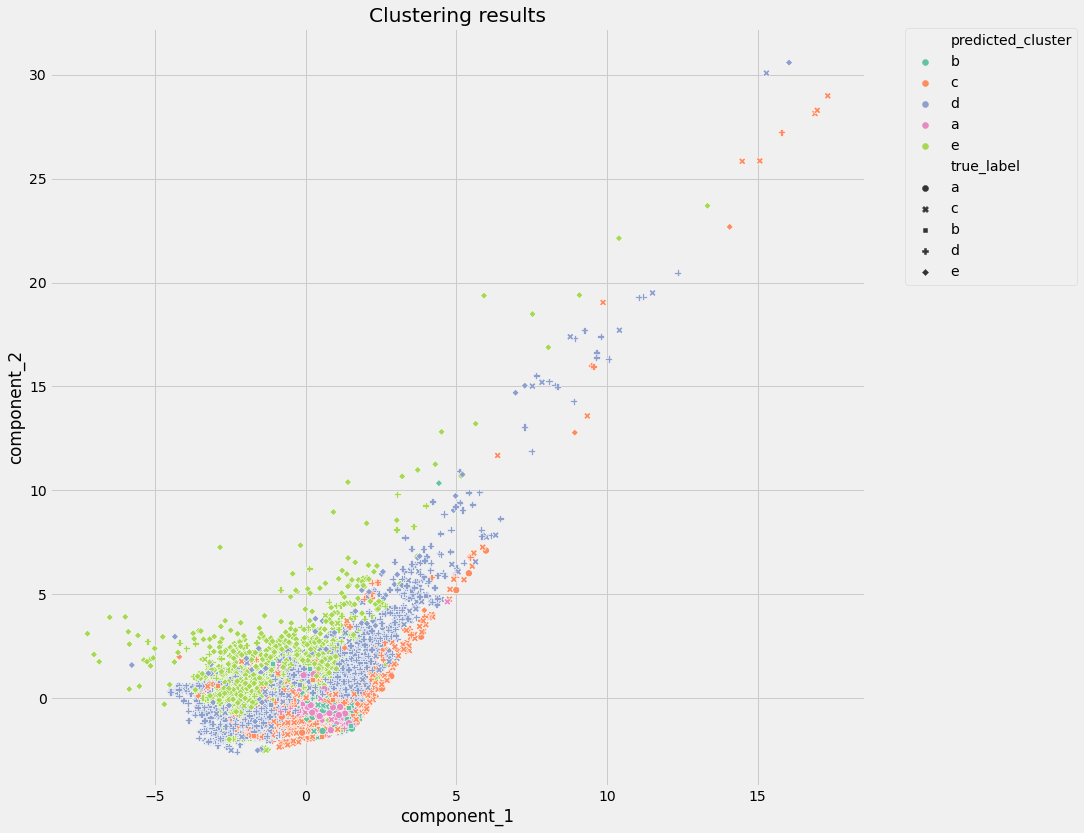

In [70]:
pcadf = pd.DataFrame(
     pipe["preprocessor"].transform(X_test),
     columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe.predict(X_test)
pcadf["true_label"] = y_test

plt.style.use("fivethirtyeight")
plt.figure(figsize=(13, 13))

scat = sns.scatterplot(
     "component_1",
     "component_2",
     s=50,
     data=pcadf,
     hue="predicted_cluster",
     style="true_label",
     palette="Set2",
)

scat.set_title(
    "Clustering results"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [71]:
conf = confusion_matrix(pcadf["true_label"], pcadf["predicted_cluster"])
conf

array([[ 7712,  1969,  1177,   597,   209],
       [ 2410,  5014,  1988,  1098,   255],
       [ 1947,  2176,  9725,  3684,   951],
       [  811,  1173,  3648, 18613,  2644],
       [  368,   260,  1133,  2999, 11475]])

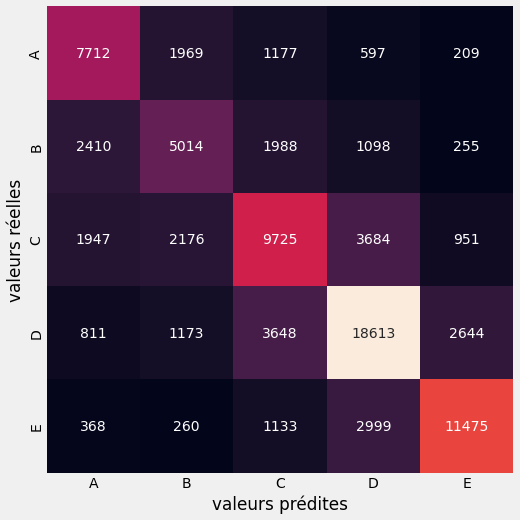

In [72]:
plt.subplots(figsize=(16,8))
sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(["A", "B", "C", "D", "E"])
            , yticklabels=list(["A", "B", "C", "D", "E"]), fmt='g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');